<a href="https://colab.research.google.com/github/Zhekuson/Findan/blob/main/Sb_1/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Первоначальная настройка

Здесь маунт, импорты и прочее  
Не забудь очистить выходы ячеек перед коммитом

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Нужно добавить ссылку на мой диск для нашей общей папки по финдану**
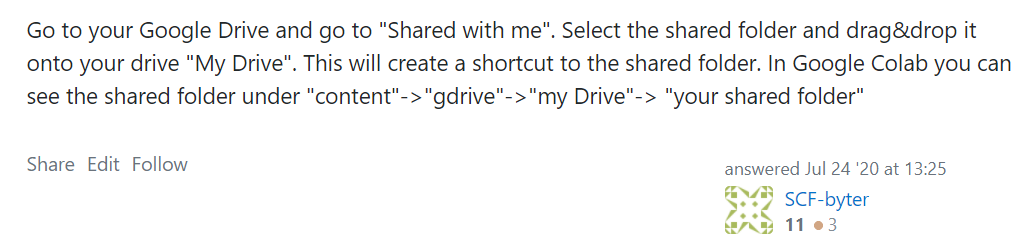

In [2]:
!ls drive/MyDrive/Findan/Sb_1
# не очищайте эту ячейку

 data   plots  'Если ты это видишь все ок'


Ссылка на папку Findan должна лежать в корне (в MyDrive)  
Если все сделано правильно, то появится доступ к общим файлам в этой папке

Сохраняться должны: **веса моделей/отчеты** - на диске,  
**выходы ячеек** - на гитхабе 

Правила по работе с *общими* ноутбуками  
1) **Строго** в отдельных ветках, иначе будет очень плохо  
2) PR в main очень аккуратно, мердж конфликты резолвим тщательно     
3) Коммиты тоже аккуратные и без лишних выводов ячеек  

Либо в отдельных ноутбуках, тогда свобода действий

# Начало

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sys

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from datetime import date

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
import keras.backend as K
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
from operator import add
import json

In [4]:
def make_ann_model(window_size):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(window_size, 1)))
    model.add(Dense(16, activation='relu'))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def make_lstm_model(window_size):
    model_lstm = Sequential()
    model_lstm.add(LSTM(256, input_shape=(window_size, 1), activation='relu', kernel_initializer='lecun_uniform',
                        return_sequences=True))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(LSTM(128, input_shape=(window_size, 1), activation='relu', kernel_initializer='lecun_uniform',
                        return_sequences=False))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(1, activation='linear'))
    model_lstm.compile(loss='mean_squared_error', optimizer='adam')

    return model_lstm


def make_cnn_model(window_size):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, 1)))
    model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    # model.add(Dense(32,activation='relu'))
    model.add(Flatten())
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')

    return model


def make_gru_model(window_size):
    model = Sequential()
    model.add(GRU(256, input_shape=(window_size, 1), activation='relu', kernel_initializer='lecun_uniform',
                  return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(128, input_shape=(window_size, 1), activation='relu', kernel_initializer='lecun_uniform',
                  return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')

    return model

def test_model(model, X_train, X_test, y_train, y_test):
    y_pred_test_ann = model.predict(X_test)
    y_train_pred_ann = model.predict(X_train)
    r2_train = mse(y_train, y_train_pred_ann)
    r2_test = mse(y_test, y_pred_test_ann)

    return r2_train, r2_test

In [5]:
symbols = ['INFY', 'BHARTIARTL', 'AXISBANK', 'CIPLA', 'HCLTECH', 'HDFC', 'ULTRACEMCO', 'ACC']
window_sizes = [3, 5, 7, 9, 11, 13, 15]

In [6]:
def window_transform(time_series, window_size):
    X = []
    y = []
    for i in range(len(time_series) - window_size):
        X.append(time_series[i:i + window_size])
        y.append(time_series[i + window_size])

    return np.array(X), np.array(y)

In [7]:
for sym in symbols:
    json_descriptor = {'stock': sym, 'ann': [], 'gru': [], 'lstm': [], 'cnn': []}
    data = pd.read_csv('drive/MyDrive/Findan/Sb_1/data/{}.csv'.format(sym), index_col=0)
    print('data loaded for {}!!'.format(sym))
    data.index = pd.to_datetime(data.index)
    data_frame = data.copy()
    df = data_frame[["Close"]]

    print(df)
    split_date = pd.Timestamp('01-01-2017')

    train = df.loc[:split_date]
    test = df.loc[split_date:]

    sc = MinMaxScaler()
    train_sc = sc.fit_transform(train)
    test_sc = sc.transform(test)

    ann = []
    gru = []
    lstm = []
    cnn = []

    for win_sz in window_sizes:
        ann_result = []
        gru_result = []
        lstm_result = []
        cnn_result = []
        pred_ANN = []
        pred_LSTM = []
        pred_GRU = []
        pred_CNN = []
        for i in range(5):
            # ''''''''ANN'''''''''''''''''''
            X_train, y_train = window_transform(train_sc, win_sz)
            X_test, y_test = window_transform(test_sc, win_sz)

            model = make_ann_model(win_sz)
            early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
            history = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1, callbacks=[early_stop],
                                shuffle=False)

            train_acc, test_acc = test_model(model, X_train, X_test, y_train, y_test)
            y_pred_test_ANN = model.predict(X_test)

            ann_result.append(test_acc)
            # ''''''''ANN''''''''''''''''''''

            # ''''''''CNN''''''''''''''''''''
            model = make_cnn_model(win_sz)
            early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
            history_model_cnn = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1, shuffle=False,
                                          callbacks=[early_stop])

            train_acc, test_acc = test_model(model, X_train, X_test, y_train, y_test)
            y_pred_test_CNN = model.predict(X_test)
            cnn_result.append(test_acc)
            # ''''''''CNN''''''''''''''''''''

            X_tr_t = X_train.reshape(X_train.shape[0], win_sz, 1)
            X_tst_t = X_test.reshape(X_test.shape[0], win_sz, 1)

            # ''''''''''LSTM''''''''''''''''''
            model = make_lstm_model(win_sz)
            early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
            history_model_lstm = model.fit(X_tr_t, y_train, epochs=200, batch_size=32, verbose=1, shuffle=False,
                                           callbacks=[early_stop])

            train_acc, test_acc = test_model(model, X_tr_t, X_tst_t, y_train, y_test)
            y_pred_test_LSTM = model.predict(X_tst_t)
            lstm_result.append(test_acc)
            # "''''''''LSTM'''''''''''''''''''

            # ''''''''GRU'''''''''''''''''''''
            model = make_gru_model(win_sz)
            early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
            history_model_gru = model.fit(X_tr_t, y_train, epochs=200, batch_size=32, verbose=1, shuffle=False,
                                          callbacks=[early_stop])

            train_acc, test_acc = test_model(model, X_tr_t, X_tst_t, y_train, y_test)
            y_pred_test_GRU = model.predict(X_tst_t)
            gru_result.append(test_acc)
            # ''''''''GRU'''''''''''''''''''''

            pred_ANN.append(y_pred_test_ANN)
            pred_CNN.append(y_pred_test_CNN)
            pred_LSTM.append(y_pred_test_LSTM)
            pred_GRU.append(y_pred_test_GRU)
        # update optimal window size param
        ann.append([win_sz, min(ann_result), np.mean(ann_result), np.std(ann_result)])
        gru.append([win_sz, min(gru_result), np.mean(gru_result), np.std(gru_result)])
        lstm.append([win_sz, min(lstm_result), np.mean(lstm_result), np.std(lstm_result)])
        cnn.append([win_sz, min(cnn_result), np.mean(cnn_result), np.std(cnn_result)])

        plot_ann = [0] * len(pred_ANN[0])
        for pred in pred_ANN:
            plot_ann = list(map(add, plot_ann, pred))

        for i in range(len(plot_ann)):
            plot_ann[i] = plot_ann[i] / 5

        plot_lstm = [0] * len(pred_LSTM[0])
        for pred in pred_LSTM:
            plot_lstm = list(map(add, plot_lstm, pred))

        for i in range(len(plot_lstm)):
            plot_lstm[i] = plot_lstm[i] / 5

        plot_gru = [0] * len(pred_GRU[0])
        for pred in pred_GRU:
            plot_gru = list(map(add, plot_gru, pred))

        for i in range(len(plot_gru)):
            plot_gru[i] = plot_gru[i] / 5

        plot_cnn = [0] * len(pred_CNN[0])
        for pred in pred_CNN:
            plot_cnn = list(map(add, plot_cnn, pred))

        for i in range(len(plot_cnn)):
            plot_cnn[i] = plot_cnn[i] / 5

        # save prediction plots
        plt.plot(y_test, '-', label='True Values', color='#1b9e77')
        plt.plot(plot_ann, label='ANN Prediction', color='#d95f02')
        plt.plot(plot_cnn, ':', label='CNN Prediction', color='#7570b3')
        plt.plot(plot_lstm, label='LSTM Prediction', color='#e7298a')
        plt.plot(plot_gru, label='GRU Prediction', color='#66a61e')
        plt.title("Prediction")
        plt.xlabel('Time')
        plt.ylabel('Normalized Stock Prices')
        plt.legend()
        plt.savefig('drive/MyDrive/Findan/Sb_1/plots/single_step/' + sym + ' ' + 'window_sz ' + str(win_sz))
        plt.clf()

Выходные данные были обрезаны до нескольких последних строк (5000).
Epoch 3/200
117/117 [==============================] - 0s 4ms/step - loss: 0.0020
Epoch 4/200
117/117 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 5/200
117/117 [==============================] - 0s 3ms/step - loss: 0.0018
Epoch 6/200
117/117 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 7/200
117/117 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 8/200
117/117 [==============================] - 1s 5ms/step - loss: 0.0014
Epoch 9/200
117/117 [==============================] - 1s 5ms/step - loss: 0.0014
Epoch 10/200
117/117 [==============================] - 1s 4ms/step - loss: 0.0012
Epoch 11/200
117/117 [==============================] - 1s 4ms/step - loss: 0.0012
Epoch 12/200
117/117 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 13/200
117/117 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 14/200
117/117 [====

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D
from keras.utils.vis_utils import plot_model
from operator import add
import json
import itertools

symbols = ['ACC', 'HCLTECH', 'JSWSTEEL', 'AXISBANK', 'INFY', 'HDFC', 'INFY', 'BHARTIARTL', 'ULTRACEMCO', 'CIPLA', 'MARUTI']

# (x, y) here x indicates the input size and y indicates the prediction size
# (30, 7) means we predict next 7 days stocks using previous 30 days prices
window_size = [(30, 7), (30, 14), (60, 7), (60, 14)]


def adj_r2_score(r2, n, k):
    return 1 - ((1 - r2) * ((n - 1) / (n - k - 1)))


def window_transform(series, input_size, output_size):
    X = []
    y = []

    slen = len(series)
    n_windows = slen - (input_size + output_size) + 1

    for i in range(n_windows):
        X.append(series[i:i + input_size])
        y.append(series[i+input_size: i+input_size+output_size])

    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1])
    y = y.reshape(y.shape[0], y.shape[1])
    return X, y


def test_window_transform(series, input_size, output_size):
    X = []
    y = []

    slen = len(series)

    j = input_size
    while (j+output_size) < slen:
        X.append(series[j - input_size:j])
        y.append(series[j:j+output_size])
        j = j + output_size

    X = np.array(X)
    y = np.array(y)
    X = X.reshape(X.shape[0], X.shape[1])
    y = y.reshape(y.shape[0], y.shape[1])
    return X, y


def make_ann_model(input_size, output_size):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(input_size,)))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(output_size, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


def make_cnn_model(input_size, output_size):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=5, strides=1, activation='relu', input_shape=(input_size, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(output_size, activation='linear'))

    model.compile(loss='mean_squared_error', optimizer='adam')

    return model


def make_lstm_model(input_size, output_size):
    model_lstm = Sequential()
    model_lstm.add(LSTM(256, input_shape=(input_size, 1), activation='relu', kernel_initializer='lecun_uniform',
                        return_sequences=True))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(LSTM(128, input_shape=(input_size, 1), activation='relu', kernel_initializer='lecun_uniform',
                        return_sequences=False))
    model_lstm.add(Dropout(0.2))
    model_lstm.add(Dense(output_size, activation='linear'))
    opt = Adam(clipnorm=1.0)
    model_lstm.compile(loss='mean_squared_error', optimizer=opt)

    return model_lstm


def make_gru_model(input_size, output_size):
    model = Sequential()
    model.add(GRU(256, input_shape=(input_size, 1), activation='relu', kernel_initializer='lecun_uniform',
                  return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(128, input_shape=(input_size, 1), activation='relu', kernel_initializer='lecun_uniform',
                  return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(output_size, activation='linear'))
    opt = Adam(clipnorm=1.0)
    model.compile(loss='mean_squared_error', optimizer=opt)

    return model


def test_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    true_ = [item for sublist in y_test for item in sublist]
    pred_ = [item for sublist in y_pred for item in sublist]

    error = mse(true_, pred_)

    return error, pred_


def plot_all_model():
    print('plotting_model')
    ann_model = make_ann_model(3)
    cnn_model = make_cnn_model(3)
    lstm_model = make_lstm_model(3)
    gru_model = make_gru_model(3)

    plot_model(ann_model, to_file='ann_plot.png', show_shapes=True, show_layer_names=True)
    plot_model(cnn_model, to_file='cnn_plot.png', show_shapes=True, show_layer_names=True)
    plot_model(lstm_model, to_file='lstm_plot.png', show_shapes=True, show_layer_names=True)
    plot_model(gru_model, to_file='gru_plot.png', show_shapes=True, show_layer_names=True)



result = []

for sym in symbols:

  json_descriptor = {'stock': sym, 'ann': [], 'gru': [], 'lstm': [], 'cnn': []}

  data = pd.read_csv('drive/MyDrive/Findan/Sb_1/data/{}.csv'.format(sym), index_col=0)
  print('data loaded for {}!!'.format(sym))
  
  data.index = pd.to_datetime(data.index)
  data_frame = data.copy()
  df = data_frame[["Close"]]

  split_date = pd.Timestamp('01-01-2017')

  train = df.loc[:split_date]
  test = df.loc[split_date:]

  sc = MinMaxScaler()
  train_sc = sc.fit_transform(train)
  test_sc = sc.transform(test)

  ann = []
  gru = []
  lstm = []
  cnn = []

  for in_size, out_size in window_size:
      ann_result = []
      gru_result = []
      lstm_result = []
      cnn_result = []
      pred_ANN = []
      pred_LSTM = []
      pred_GRU = []
      pred_CNN = []
      for i in range(5):
          # ''''''''ANN'''''''''''''''''''
          X_train, y_train = window_transform(train_sc, in_size, out_size)
          print('X train: ', X_train.shape)
          print('y train: ', y_train.shape)
          X_test, y_test = test_window_transform(test_sc, in_size, out_size)
          flat_y_test = [item for sublist in y_test for item in sublist]
          print('X test: ', X_test.shape)
          print('y test: ', y_test.shape)
          model = make_ann_model(in_size, out_size)
          early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)
          history = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1, callbacks=[early_stop],
                              shuffle=False)

          error, pred_ann = test_model(model, X_test, y_test)

          ann_result.append(error)
          # ''''''''ANN''''''''''''''''''''

          # ''''''''CNN''''''''''''''''''''
          X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
          y_train = y_train.reshape(y_train.shape[0], y_train.shape[1])
          print('X train: ', X_train.shape)
          print('y train: ', y_train.shape)
          X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
          y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
          print('X train: ', X_train.shape)
          print('y train: ', y_train.shape)
          model = make_cnn_model(in_size, out_size)
          print(model.summary())
          early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
          history_model_cnn = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1, shuffle=False,
                                        callbacks=[early_stop])

          error, pred_cnn = test_model(model, X_test, y_test)
          cnn_result.append(error)
          # ''''''''CNN''''''''''''''''''''

          # ''''''''''LSTM''''''''''''''''''
          model = make_lstm_model(in_size, out_size)
          print(model.summary())
          early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
          history_model_lstm = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1,
                                          shuffle=False, callbacks=[early_stop])

          error, pred_lstm = test_model(model, X_test, y_test)
          lstm_result.append(error)
          # "''''''''LSTM'''''''''''''''''''

          # ''''''''GRU'''''''''''''''''''''
          model = make_gru_model(in_size, out_size)
          early_stop = EarlyStopping(monitor='loss', patience=3, verbose=1)
          history_model_gru = model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1, shuffle=False,
                                        callbacks=[early_stop])

          error, pred_gru = test_model(model, X_test, y_test)
          gru_result.append(error)
          # ''''''''GRU'''''''''''''''''''''

          pred_ANN.append(pred_ann)
          pred_CNN.append(pred_cnn)
          pred_LSTM.append(pred_lstm)
          pred_GRU.append(pred_gru)
      # update optimal window size param
      ann.append([in_size, out_size, min(ann_result), np.mean(ann_result), np.std(ann_result)])
      gru.append([in_size, out_size, min(gru_result), np.mean(gru_result), np.std(gru_result)])
      lstm.append([in_size, out_size, min(lstm_result), np.mean(lstm_result), np.std(lstm_result)])
      cnn.append([in_size, out_size, min(cnn_result), np.mean(cnn_result), np.std(cnn_result)])

      plot_ann = [0] * len(pred_ANN[0])
      for pred in pred_ANN:
          plot_ann = list(map(add, plot_ann, pred))

      for i in range(len(plot_ann)):
          plot_ann[i] = plot_ann[i] / 5

      plot_lstm = [0] * len(pred_LSTM[0])
      for pred in pred_LSTM:
          plot_lstm = list(map(add, plot_lstm, pred))

      for i in range(len(plot_lstm)):
          plot_lstm[i] = plot_lstm[i] / 5

      plot_gru = [0] * len(pred_GRU[0])
      for pred in pred_GRU:
          plot_gru = list(map(add, plot_gru, pred))

      for i in range(len(plot_gru)):
          plot_gru[i] = plot_gru[i] / 5

      plot_cnn = [0] * len(pred_CNN[0])
      for pred in pred_CNN:
          plot_cnn = list(map(add, plot_cnn, pred))

      for i in range(len(plot_cnn)):
          plot_cnn[i] = plot_cnn[i] / 5

      # save prediction plots
      plt.plot(flat_y_test, '-', label='True Values', color='#1b9e77')
      plt.plot(plot_ann, label='MLP Prediction', color='#d95f02')
      plt.plot(plot_cnn, ':', label='CNN Prediction', color='#7570b3')
      plt.plot(plot_lstm, label='LSTM Prediction', color='#e7298a')
      plt.plot(plot_gru, label='GRU Prediction', color='#66a61e')
      plt.title("Prediction")
      plt.xlabel('Time')
      plt.ylabel('Normalized Stock Prices')
      plt.legend()
      plt.savefig('drive/MyDrive/Findan/Sb_1/plots/multi_step/' + sym + ' ' + ' in_sz ' + str(in_size) + ' out_sz ' + str(out_size))
      plt.clf()
      
      print(y_test)
      print(plot_ann)
      # save prediction plots
      df = pd.DataFrame(zip(flat_y_test, plot_ann, plot_cnn, plot_lstm, plot_gru), columns = ['actual', 'ann', 'cnn', 'lstm', 'gru'])
      df.to_csv(path_or_buf='drive/MyDrive/Findan/Sb_1/predictions/multi_step/predictions_{}_{}_{}.csv'.format(sym, in_size, out_size))

  json_descriptor['ann'] = ann
  json_descriptor['lstm'] = lstm
  json_descriptor['cnn'] = cnn
  json_descriptor['gru'] = gru
  result.append(json_descriptor)

  with open('data.json', 'w') as f:
      json.dump(result, f)

data loaded for ACC!!
X train:  (3704, 30)
y train:  (3704, 7)
X test:  (67, 30)
y test:  (67, 7)
Epoch 1/200
116/116 [==============================] - 1s 2ms/step - loss: 0.0217
Epoch 2/200
116/116 [==============================] - 0s 1ms/step - loss: 0.0037
Epoch 3/200
116/116 [==============================] - 0s 1ms/step - loss: 0.0028
Epoch 4/200
116/116 [==============================] - 0s 2ms/step - loss: 0.0023
Epoch 5/200
116/116 [==============================] - 0s 2ms/step - loss: 0.0019
Epoch 6/200
116/116 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 7/200
116/116 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 8/200
116/116 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 9/200
116/116 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 10/200
116/116 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 11/200
116/116 [==============================] - 0s 2ms/step - loss: 0.001